In [112]:
import pandas as pd
import matplotlib.pyplot as plt

# Data Loading
####Reading the excel files for population, On-track and off-track countries, and Indicators Coverage data


In [93]:
pop_data = pd.read_excel("https://github.com/Nabilmg/P3/raw/main/WPP2022_GEN_F01_DEMOGRAPHIC_INDICATORS_COMPACT_REV1.xlsx",
                                  sheet_name='Projections', header=16) #population data

In [94]:
countries_data = pd.read_excel("https://github.com/Nabilmg/P3/raw/main/On-track%20and%20off-track%20countries.xlsx") #On-track and off-track countries
countries_data.head(10)

,ISO3Code,OfficialName,Status.U5MR
0,AFG,Afghanistan,Acceleration Needed
1,AGO,Angola,Acceleration Needed
2,AIA,Anguilla,Achieved
3,ALB,Albania,Achieved
4,AND,Andorra,Achieved
5,ARE,United Arab Emirates,Achieved
6,ARG,Argentina,Achieved
7,ARM,Armenia,Achieved
8,ATG,Antigua and Barbuda,Achieved
9,AUS,Australia,Achieved


In [104]:
ind_data = pd.read_excel("https://github.com/Nabilmg/P3/raw/main/GLOBAL_DATAFLOW_2018-2022.xlsx", skiprows=2) #Indicators Coverage data

#Data Cleaning
####Population Data

In [96]:
#Select and rename the required columns
filtered_pop_data = pop_data.loc[:, ['ISO3 Alpha-code', 'Region, subregion, country or area *', 'Births (thousands)']].copy()

# Rename columns as requested
filtered_pop_data.rename(columns={
    'ISO3 Alpha-code': 'ISO3 Alpha-code',
    'Region, subregion, country or area *': 'Country',
    'Births (thousands)': 'Births (thousands)'
}, inplace=True)

# Filter for 'Type' equal to 'Country/Area' and 'Year' equal to 2022
filtered_pop_data = filtered_pop_data[(pop_data['Type'] == 'Country/Area') & (pop_data['Year'] == 2022)]

#Countries

In [101]:
# Rename 'OfficialName' to 'Country'
countries_data.rename(columns={'OfficialName': 'Country'}, inplace=True)

# Replace the values in 'Status.U5MR'
countries_data['Status.U5MR'] = countries_data['Status.U5MR'].replace({
    'Achieved': 'On-track',
    'Acceleration Needed': 'Off-track'
})

# Display the modified DataFrame
countries_data.head()

,ISO3Code,Country,Status.U5MR
0,AFG,Afghanistan,Off-track
1,AGO,Angola,Off-track
2,AIA,Anguilla,On-track
3,ALB,Albania,On-track
4,AND,Andorra,On-track


####Indicators Coverage


1.   Rename the column headers since we skipped two rows, this is due to the structure of the file
2.   replace '-' with NAN to ease working with data
3.   getting the latest value of the indicators across the years

In [105]:
# Define new column names based on the structure of the indicators table
new_column_names = [
    'Country',
    'Indicator',
    'Gender',
    'Year_2018',
    'Year_2019',
    'Year_2020',
    'Year_2021',
    'Year_2022'
]

# Rename the columns
ind_data.columns = new_column_names

In [107]:
# Filter only the countries that is available in the On track off track list
filtered_ind_data = ind_data[ind_data['Country'].isin(countries_data['Country'])].copy()

# Replace '-' with NaN to make it easier to work with the data
filtered_ind_data.replace('-', pd.NA, inplace=True)

# Define a function to get the latest non-NaN value for each row
def get_latest_value(row):
    for col in reversed(row.index):
        if pd.notna(row[col]):
            return row[col]
    return pd.NA

# Apply the function to the year columns
filtered_ind_data['Indicator Value'] = filtered_ind_data[['Year_2018', 'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022']].apply(get_latest_value, axis=1)

# Drop the old year columns and keep only the latest value
filtered_ind_data = filtered_ind_data.drop(columns=['Year_2018', 'Year_2019', 'Year_2020', 'Year_2021', 'Year_2022'])

# Drop the 'Gender' column since it's no longer needed
filtered_ind_data.drop(columns=['Gender'], inplace=True)

# Remove rows where the 'Indicator' is NaN
filtered_ind_data.dropna(subset=['Indicator'], inplace=True)

# Replace the Indicator names with the abbreviations ANC4 and SAB
filtered_ind_data['Indicator'] = filtered_ind_data['Indicator'].replace({
    'Antenatal care 4+ visits - percentage of women (aged 15-49 years) attended at least four times during pregnancy by any provider': 'ANC4',
    'Skilled birth attendant - percentage of deliveries attended by skilled health personnel': 'SAB'
})


# Pivot the table to have one row per country with columns for ANC4 and SAB
final_ind_table = filtered_ind_data.pivot(index='Country', columns='Indicator', values='Indicator Value').reset_index()

# Display the final table
final_ind_table.head(10)

Indicator,Country,ANC4,SAB
0,Afghanistan,20.9,58.8
1,Albania,77.8,99.8
2,Algeria,69.8,98.8
3,Anguilla,NaN,100
4,Antigua and Barbuda,NaN,99
5,Argentina,90.4,99.5
6,Australia,NaN,98.7
7,Austria,NaN,98.4
8,Azerbaijan,NaN,99.4
9,Bahamas,NaN,99


#Merging Tables

In [109]:
# Merge final_ind_table with filtered_pop_data and countries_data on 'Country'
merged_data = pd.merge(final_ind_table,
                       filtered_pop_data[['Country', 'Births (thousands)']],
                       on='Country',
                       how='left')

# Merge the result with countries_data to include 'Status.U5MR'
merged_data = pd.merge(merged_data,
                       countries_data[['Country', 'Status.U5MR']],
                       on='Country',
                       how='left')

# Display the merged DataFrame
merged_data.head(10)

,Country,ANC4,SAB,Births (thousands),Status.U5MR
0,Afghanistan,20.9,58.8,1446.699,Off-track
1,Albania,77.8,99.8,28.795,On-track
2,Algeria,69.8,98.8,923.648,On-track
3,Anguilla,NaN,100,0.15,On-track
4,Antigua and Barbuda,NaN,99,1.124,On-track
5,Argentina,90.4,99.5,627.741,On-track
6,Australia,NaN,98.7,300.246,On-track
7,Austria,NaN,98.4,84.394,On-track
8,Azerbaijan,NaN,99.4,123.673,On-track
9,Bahamas,NaN,99,4.659,On-track


#Calculating Weighted Average

In [111]:
# Convert the columns to numeric, forcing errors to NaN
merged_data['ANC4'] = pd.to_numeric(merged_data['ANC4'], errors='coerce')
merged_data['SAB'] = pd.to_numeric(merged_data['SAB'], errors='coerce')
merged_data['Births (thousands)'] = pd.to_numeric(merged_data['Births (thousands)'], errors='coerce')

# Drop rows where Births (thousands) is NaN since we can't calculate the weighted average without it
merged_data.dropna(subset=['Births (thousands)'], inplace=True)

# Filter the data for On-track and Off-track countries
on_track_data = merged_data[merged_data['Status.U5MR'] == 'On-track']
off_track_data = merged_data[merged_data['Status.U5MR'] == 'Off-track']

# Function to calculate weighted average
def weighted_average(df, value_column, weight_column):
    return (df[value_column] * df[weight_column]).sum() / df[weight_column].sum()

# Calculate weighted averages for On-track countries
on_track_anc4_weighted_avg = weighted_average(on_track_data, 'ANC4', 'Births (thousands)')
on_track_sab_weighted_avg = weighted_average(on_track_data, 'SAB', 'Births (thousands)')

# Calculate weighted averages for Off-track countries
off_track_anc4_weighted_avg = weighted_average(off_track_data, 'ANC4', 'Births (thousands)')
off_track_sab_weighted_avg = weighted_average(off_track_data, 'SAB', 'Births (thousands)')

# Display the results
print(f"On-track Weighted Average ANC4: {on_track_anc4_weighted_avg:.2f}")
print(f"On-track Weighted Average SAB: {on_track_sab_weighted_avg:.2f}")
print(f"Off-track Weighted Average ANC4: {off_track_anc4_weighted_avg:.2f}")
print(f"Off-track Weighted Average SAB: {off_track_sab_weighted_avg:.2f}")

On-track Weighted Average ANC4: 57.71
On-track Weighted Average SAB: 71.64
Off-track Weighted Average ANC4: 51.91
Off-track Weighted Average SAB: 51.73


#Visualzing Results

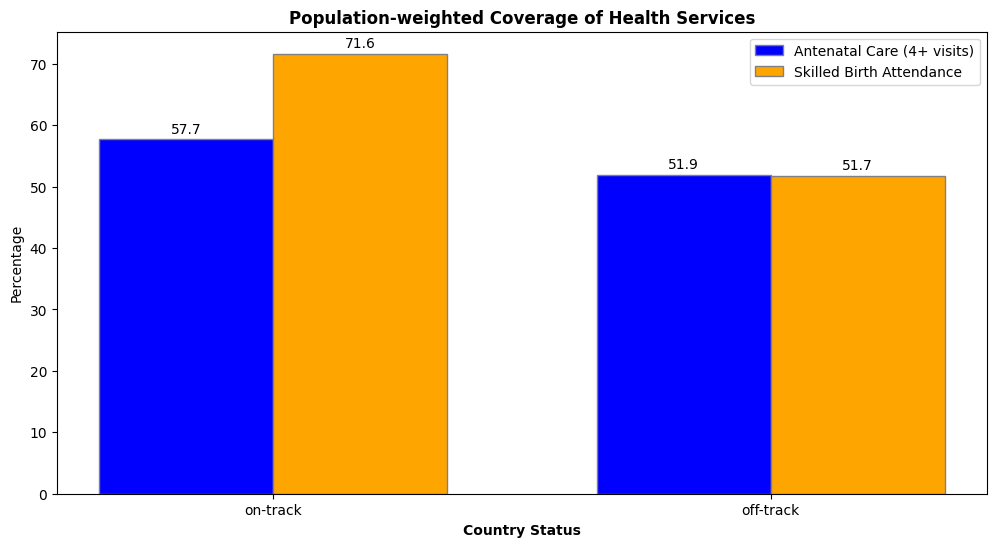

In [113]:
# Data for plotting
categories = ['on-track', 'off-track']
anc4_values = [on_track_anc4_weighted_avg, off_track_anc4_weighted_avg]
sab_values = [on_track_sab_weighted_avg, off_track_sab_weighted_avg]

# Bar width
bar_width = 0.35

# Positions of the bars on the x-axis
r1 = range(len(categories))
r2 = [x + bar_width for x in r1]

# Create the bar chart
plt.figure(figsize=(12, 6))
plt.bar(r1, anc4_values, color='blue', width=bar_width, edgecolor='grey', label='Antenatal Care (4+ visits)')
plt.bar(r2, sab_values, color='orange', width=bar_width, edgecolor='grey', label='Skilled Birth Attendance')

# Add xticks on the middle of the group bars
plt.xlabel('Country Status', fontweight='bold')
plt.xticks([r + bar_width/2 for r in range(len(categories))], categories)

# Add labels to the top of each bar
for i in range(len(r1)):
    plt.text(r1[i], anc4_values[i] + 1, f'{anc4_values[i]:.1f}', ha='center')
    plt.text(r2[i], sab_values[i] + 1, f'{sab_values[i]:.1f}', ha='center')

# Add title and labels
plt.title('Population-weighted Coverage of Health Services', fontweight='bold')
plt.ylabel('Percentage')

# Add legend
plt.legend()

# Show the plot
plt.show()


The bar chart above illustrates the population-weighted coverage percentages for two key health services—Antenatal Care (4+ visits) and Skilled Birth Attendance—across on-track and off-track countries:

####On-Track Countries:
*   Antenatal Care (4+ visits) Coverage: The average population-weighted coverage for ANC4 is 57.71%.
*   Skilled Birth Attendance Coverage: The average population-weighted coverage for SAB is higher at 71.64%.

####Off-Track Countries:
*   Antenatal Care (4+ visits) Coverage: The average population-weighted coverage for ANC4 is slightly lower at 51.91%.
*   Skilled Birth Attendance Coverage: The average population-weighted coverage for SAB is 51.73%.

####Interpretation:
#####On-Track vs. Off-Track:
*   The analysis shows a disparity in health service coverage between on-track and off-track countries. On-track countries have higher coverage for both ANC4 and SAB, although the differences are not as pronounced as might be expected.
*   For Antenatal Care (ANC4), on-track countries have a weighted average coverage of 57.71%, which is only slightly higher than the 51.91% in off-track countries. This suggests that both groups of countries need further improvements in providing adequate antenatal care.
*   The gap is slightly wider for Skilled Birth Attendance (SAB), with on-track countries having a coverage of 71.64% compared to 51.73% in off-track countries. This indicates better access to skilled health personnel during childbirth in on-track countries.
#####Policy Implications:
*   The relatively small differences in coverage between on-track and off-track countries, particularly for ANC4, suggest that both groups face significant challenges in maternal health service coverage.
*   These findings underscore the importance of not only maintaining progress in on-track countries but also intensifying efforts in off-track countries to improve both antenatal care and skilled birth attendance. Enhancing these services is essential for reducing maternal and child mortality and achieving broader health objectives, including those outlined in the Sustainable Development Goals (SDGs).
*   Targeted interventions are needed, especially in off-track countries, to close the gap in SAB coverage and improve ANC4 coverage, which is crucial for the health and well-being of mothers and newborns.

In conclusion, while on-track countries perform better in health service coverage, the relatively modest differences point to a widespread need for improvement across both groups. This analysis calls for sustained and enhanced efforts to ensure that all women, regardless of their country's status, have access to essential maternal health services.